<a href="https://colab.research.google.com/github/hissain/mlworks/blob/main/codes/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook is made by using the following resources:
https://github.com/sauravraghuvanshi/Udacity-Computer-Vision-Nanodegree-Program.git
https://medium.com/@deepeshrishu09/automatic-image-captioning-with-pytorch-cf576c98d319
https://www.kaggle.com/code/mdteach/image-captioning-with-out-attention-pytorch

[Download dataset from here](https://drive.google.com/file/d/1kAIOAyyy93thbhibaIn9N8D6-lppQf3x/view?usp=drive_link)

### Drive Mounting for dataset loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/BRTC/IAC/GenerativeAICourse/March2024/Notebooks/data/image-captioning/archive.zip' > temp.txt

In [ ]:
#imports
import numpy as np
import torch
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

### 1) Exploring the dataset</h2>
<p>Reading the image data and their corresponding captions from the flick dataset folder. Showing the image and captions to get the insighs of the data. Dowload link for the dataset used <a href="https://www.kaggle.com/adityajn105/flickr8k">here</a></p>

In [ ]:
#location of the data
data_location =  "./"
!ls $data_location

captions.txt  drive  Images  sample_data  temp.txt


In [ ]:
#reading the text data
import pandas as pd
caption_file = data_location + '/captions.txt'
df = pd.read_csv(caption_file)
print("There are {} image to captions".format(len(df)))
df.head(7)

There are 40455 image to captions


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...


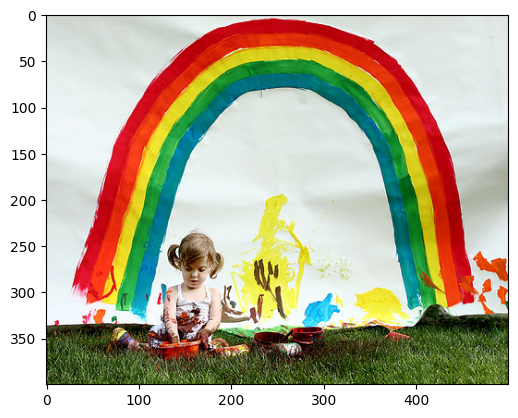

Caption: A little girl is sitting in front of a large painted rainbow .
Caption: A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
Caption: There is a girl with pigtails sitting in front of a rainbow painting .
Caption: Young girl with pigtails painting outside in the grass .
Caption: A man lays on a bench while his dog sits by him .


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#select any index from the whole dataset
#single image has 5 captions
#so, select indx as: 1,6,11,16...
data_idx = 11

image_path = data_location+"/Images/"+df.iloc[data_idx,0]
img=mpimg.imread(image_path)
plt.imshow(img)
plt.show()

#image consits of 5 captions,
#showing all 5 captions of the image of the given idx
for i in range(data_idx,data_idx+5):
    print("Caption:",df.iloc[i,1])


### 2) Writing the custom dataset
<p>Writing the custom torch dataset class so, that we can abastract out the dataloading steps during the training and validation process</p>
<p>Here, dataloader is created which gives the batch of image and its captions with following processing done:</p>

<li>caption word tokenized to unique numbers</li>
<li>vocab instance created to store all the relivent words in the datasets</li>
<li>each batch, caption padded to have same sequence length</li>
<li>image resized to the desired size and converted into captions</li>

<br><p>In this way the dataprocessing is done, and the dataloader is ready to be used with <b>Pytorch</b></p>

In [ ]:
#imports
import os
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

from PIL import Image

In [ ]:
#using spacy for the better text tokenization
spacy_eng = spacy.load("en_core_web_sm")

#example
text = "This is a good place to find a city"
[token.text.lower() for token in spacy_eng.tokenizer(text)]

['this', 'is', 'a', 'good', 'place', 'to', 'find', 'a', 'city']

In [ ]:
class Vocabulary:
    def __init__(self,freq_threshold):
        #setting the pre-reserved tokens int to string tokens
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}

        #string to int tokens
        #its reverse dict self.itos
        self.stoi = {v:k for k,v in self.itos.items()}

        self.freq_threshold = freq_threshold

    def __len__(self): return len(self.itos)

    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]

    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1

                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(text)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]

In [ ]:
#testing the vicab class
v = Vocabulary(freq_threshold=1)

v.build_vocab(["This is a good place to find a city"])
print(v.stoi)
print(v.numericalize("This is a good place to find a city here!!"))

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'this': 4, 'is': 5, 'a': 6, 'good': 7, 'place': 8, 'to': 9, 'find': 10, 'city': 11}
[4, 5, 6, 7, 8, 9, 10, 6, 11, 3, 3, 3]


In [ ]:
class FlickrDataset(Dataset):
    """
    FlickrDataset
    """
    def __init__(self,root_dir,captions_file,transform=None,freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(caption_file)
        self.transform = transform

        #Get image and caption colum from the dataframe
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        #Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())


    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")

        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)

        #numericalize the caption text
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]

        return img, torch.tensor(caption_vec)

In [ ]:
#defing the transform to be applied
transforms = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])

In [ ]:
def show_image(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

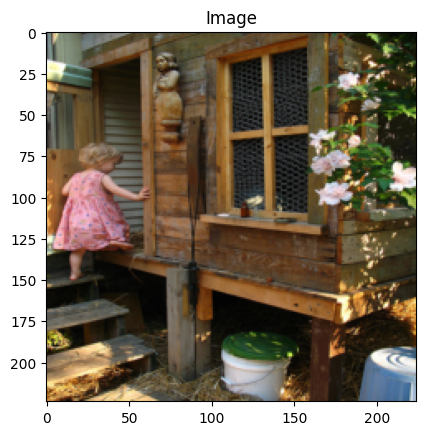

Token: tensor([  1,   4,  28,   8,   4, 195, 151,  17,  32,  67,   4, 353,  11, 711,
          8,  24,   3, 496,   5,   2])
Sentence:
['<SOS>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', '<UNK>', 'way', '.', '<EOS>']


In [ ]:
#testing the dataset class
dataset =  FlickrDataset(
    root_dir = data_location+"/Images",
    captions_file = data_location+"/captions.txt",
    transform=transforms
)

img, caps = dataset[0]
show_image(img,"Image")
print("Token:",caps)
print("Sentence:")
print([dataset.vocab.itos[token] for token in caps.tolist()])

In [ ]:
class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)

        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

In [ ]:
#writing the dataloader
#setting the constants
BATCH_SIZE = 4
NUM_WORKER = 1

#token to represent the padding
pad_idx = dataset.vocab.stoi["<PAD>"]

data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


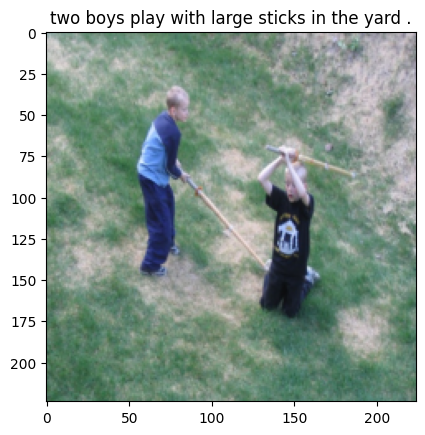

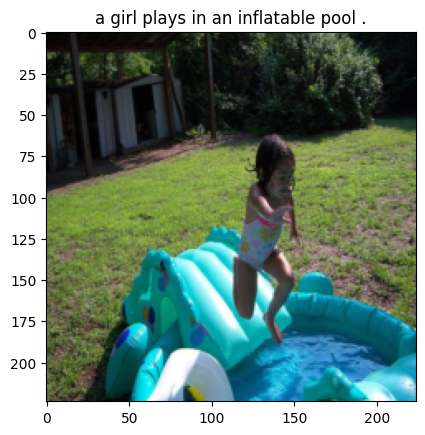

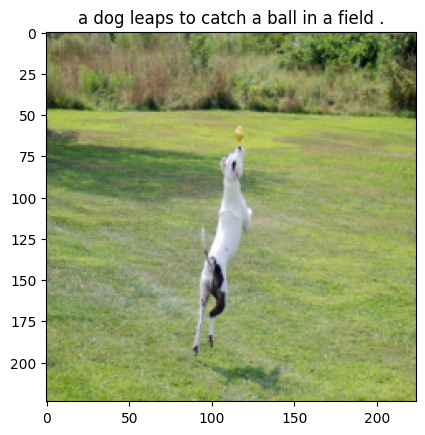

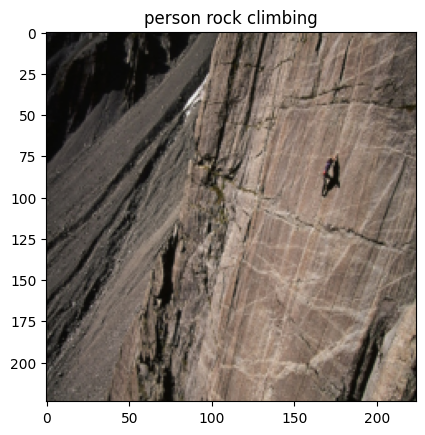

In [ ]:
#generating the iterator from the dataloader
dataiter = iter(data_loader)

#getting the next batch
batch = next(dataiter)

#unpacking the batch
images, captions = batch

#showing info of image in single batch
for i in range(BATCH_SIZE):
    img,cap = images[i],captions[i]
    caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)
    show_image(img,caption_label)
    plt.show()

### 3) Defining the Model Architecture

Model is seq2seq model. In the **encoder** pretrained ResNet model is used to extract the features. Decoder, is the implementation of the Bahdanau Attention Decoder. In the decoder model **LSTM cell**.

In [ ]:
#Initiate the Dataset and Dataloader

#setting the constants
BATCH_SIZE = 256
# BATCH_SIZE = 6
NUM_WORKER = 4

#vocab_size
vocab_size = len(dataset.vocab)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.batch = nn.BatchNorm1d(embed_size, momentum = 0.01)
        self.embed.weight.data.normal_(0., 0.02)
        self.embed.bias.data.fill_(0)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.batch(self.embed(features))
        return features

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        ''' Initialize the layers of this model.'''
        super().__init__()

        # Keep track of hidden_size for initialization of hidden state
        self.hidden_size = hidden_size

        # Embedding layer that turns words into a vector of a specified size
        self.word_embeddings = nn.Embedding(vocab_size, embed_size)

        # The LSTM takes embedded word vectors (of a specified size) as input
        # and outputs hidden states of size hidden_dim
        self.lstm = nn.LSTM(
            input_size=embed_size,
            hidden_size=hidden_size, # LSTM hidden units
            num_layers=256, # number of LSTM layer
            bias=True, # use bias weights b_ih and b_hh
            batch_first=True,  # input & output will have batch size as 1st dimension
            dropout=0, # Not applying dropout
            bidirectional=False, # unidirectional LSTM
        )

        # The linear layer that maps the hidden state output dimension
        # to the number of words we want as output, vocab_size
        self.linear = nn.Linear(hidden_size, vocab_size)

        # initialize the hidden state
        # self.hidden = self.init_hidden()

    def init_hidden(self, batch_size):
        """ At the start of training, we need to initialize a hidden state;
        there will be none because the hidden state is formed based on previously seen data.
        So, this function defines a hidden state with all zeroes
        The axes semantics are (num_layers, batch_size, hidden_dim)
        """
        return (torch.zeros((1, batch_size, self.hidden_size), device=device), \
                torch.zeros((1, batch_size, self.hidden_size), device=device))

    def forward(self, features, captions):
        """ Define the feedforward behavior of the model """

        # Discard the <end> word to avoid predicting when <end> is the input of the RNN
        captions = captions[:, :-1]

        # Initialize the hidden state
        batch_size = features.shape[0] # features is of shape (batch_size, embed_size)
        self.hidden = self.init_hidden(batch_size)

        # Create embedded word vectors for each word in the captions
        embeddings = self.word_embeddings(captions) # embeddings new shape : (batch_size, captions length - 1, embed_size)

        # Stack the features and captions
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1) # embeddings new shape : (batch_size, caption length, embed_size)

        # Get the output and hidden state by passing the lstm over our word embeddings
        # the lstm takes in our embeddings and hidden state
        lstm_out, self.hidden = self.lstm(embeddings, self.hidden) # lstm_out shape : (batch_size, caption length, hidden_size)

        # Fully connected layer
        outputs = self.linear(lstm_out) # outputs shape : (batch_size, caption length, vocab_size)

        return outputs

    def sample(self, inputs):
        " accepts pre-processed image tensor (inputs) and returns predicted sentence (list of tensor ids of length max_len) "
        output = []
        batch_size = inputs.shape[0] # batch_size is 1 at inference, inputs shape : (1, 1, embed_size)
        hidden = self.init_hidden(batch_size) # Get initial hidden state of the LSTM

        for i in range(30):
            lstm_out, hidden = self.lstm(inputs, hidden) # lstm_out shape : (1, 1, hidden_size)
            outputs = self.linear(lstm_out)  # outputs shape : (1, 1, vocab_size)
            outputs = outputs.squeeze(1) # outputs shape : (1, vocab_size)

            # print(outputs.size())

            _, max_indice = torch.max(outputs, dim=1) # predict the most likely next word, max_indice shape : (1)
            # print(max_indice.size())
            output.append(max_indice.item()) # storing the word predicted

            if (max_indice == 2):
                # We predicted the <end> word, so there is no further prediction to do
                break

            ## Prepare to embed the last predicted word to be the new input of the lstm
            inputs = self.word_embeddings(max_indice) # inputs shape : (1, embed_size)
            inputs = inputs.unsqueeze(1) # inputs shape : (1, 1, embed_size)

        return output

    def get_outputs(self, inputs, hidden):
        lstm_out, hidden = self.lstm(inputs, hidden) # lstm_out shape : (1, 1, hidden_size)
        outputs = self.linear(lstm_out)  # outputs shape : (1, 1, vocab_size)
        outputs = outputs.squeeze(1) # outputs shape : (1, vocab_size)

        return outputs, hidden

    def get_next_word_input(self, max_indice):
        ## Prepare to embed the last predicted word to be the new input of the lstm
        inputs = self.word_embeddings(max_indice) # inputs shape : (1, embed_size)
        inputs = inputs.unsqueeze(1) # inputs shape : (1, 1, embed_size)

        return inputs

In [ ]:
print(vocab_size)

2994


In [ ]:
batch_size = 32            # batch size

embed_size = 512           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder

# Initialize the encoder and decoder.
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

# Define the loss function.
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# TODO #3: Specify the learnable parameters of the model.
params = list(decoder.parameters()) + list(encoder.embed.parameters()) + list(encoder.batch.parameters())

# TODO #4: Define the optimizer.
optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)
# optimizer = torch.optim.Adam(params, lr=0.01, betas=(0.9, 0.999), eps=1e-08)
# optimizer = torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 145MB/s]


In [ ]:
num_epochs = 1             # number of training epochs (1 for testing)

# Training
for epoch in range(num_epochs):
    for images, captions in data_loader:
        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)

        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()

        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)

        # Calculate the batch loss.
        loss = criterion(outputs.contiguous().view(-1, vocab_size), captions.view(-1))
        print(loss.item())

        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()



Streaming output truncated to the last 5000 lines.
2.6116535663604736
3.4447147846221924
2.2579028606414795
1.5836470127105713
1.5487158298492432
2.715085506439209
2.0118391513824463
1.4498167037963867
1.885573387145996
1.422823429107666
1.9584670066833496
2.1201224327087402
2.322427988052368
2.2832818031311035
1.5924029350280762
2.4008164405822754
2.699337959289551
2.31976580619812
1.546950101852417
1.6032170057296753
1.114855408668518
2.6791908740997314
1.4397964477539062
1.8736376762390137
2.1788344383239746
1.9256477355957031
2.245631456375122
2.1189255714416504
2.5264699459075928
2.9420816898345947
1.9030081033706665
2.2581939697265625
2.681813955307007
2.8365328311920166
2.1228792667388916
2.7889933586120605
2.6090354919433594
2.7618188858032227
2.28816556930542
2.5738165378570557
1.85507071018219
4.102306842803955
2.2167246341705322
2.1266512870788574
1.8427398204803467
1.4873480796813965
2.02447772026062
1.710612177848816
2.248007297515869
2.604609966278076
1.9373871088027954
1

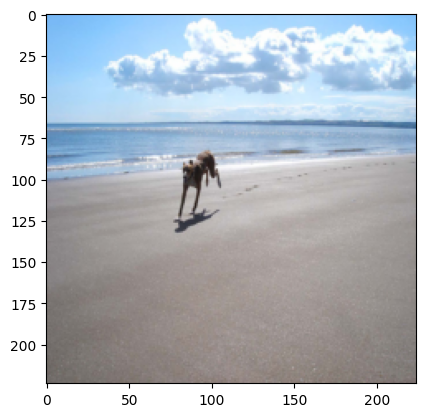

<SOS> a man in a blue jacket and blue pants is standing on a mountain . <EOS>


In [ ]:
with torch.no_grad():
    images, captions = next(iter(data_loader))
    image = images[0]

    show_image(image)
    image = image.to(device)

    features = encoder(images)[0, :].unsqueeze(0).unsqueeze(1)
    output = decoder.sample(features)
    print(" ".join([dataset.vocab.itos[token] for token in output]))